In [1]:
import os
os.makedirs('out', exist_ok=True)

### Google Colabを利用する場合は、次のセルの全行の#を1つ削除して実行する

In [2]:
##!apt-get -y install fonts-ipafont-gothic
##!pip install japanize_matplotlib

## Google Colabを利用する場合に以下のコマンドでGoogle Driveをマウント
#from google.colab import drive
#drive.mount('/content/drive')

## データフレームへの読み込み
## Google DriveのColab Notebooksにダウンロードしたフォルダ(marketing)をセットすることを想定
#iPath = '/content/drive/MyDrive/Colab Notebooks/marketing/Chapter_5/in/'
#iFile=iPath+'mtra2gc.csv'
#iCategory=iPath+'category.csv'

#import pandas as pd

## データインポート
#df = pd.read_csv(iFile)
#category = pd.read_csv(iCategory)

In [3]:
# コード 5.6 相関ルール一覧表の整形
import pandas as pd

# データインポート
df = pd.read_csv('in/mtra2gc.csv')
category = pd.read_csv('in/category.csv')

In [4]:
# 細分類名称を追加して読みやすいように整形する
cat = category[['細分類', '細分類名']]
ds = pd.merge(df, cat, left_on='node1', right_on='細分類')
ds = pd.merge(ds, cat, left_on='node2', right_on='細分類')

# 頻度の降順で並び替え
ds = ds.sort_values(by='frequency', ascending=False)
ds = ds.reset_index(drop=True)  # 並び変えたのでindexを降り直す

# 列の抜き出しと列名変更
ds = ds[['node1', '細分類名_x', 'node2', '細分類名_y', 'lift', 'jaccard']]
ds = ds.rename(columns={'node1': 'X_num', '細分類名_x': 'X_name',
               'node2': 'Y_num', '細分類名_y': 'Y_name', 'jaccard': 'jc'})
ds.head()

,X_num,X_name,Y_num,Y_name,lift,jc
0,111301,食パン,140401,牛乳,1.471567,0.150508
1,140401,牛乳,111301,食パン,1.471567,0.150508
2,140401,牛乳,130205,ヨーグルト,1.545513,0.154638
3,130205,ヨーグルト,140401,牛乳,1.545513,0.154638
4,111801,豆腐,140401,牛乳,1.524232,0.143820


In [5]:
# コード 5.7 ランク情報の付与
def calRank(df, val):

    df['rankX-Y_%s' % val] = df.groupby('X_num')['%s' %
                                                 val].rank(ascending=False, method='first')
    df['rankY-X_%s' % val] = df.groupby('Y_num')['%s' %
                                                 val].rank(ascending=False, method='first')
    return df


df = calRank(ds, 'jc')
Rules = calRank(df, 'lift')
display(Rules)

# 中間ファイルとして必要に応じて保存
Rules.to_csv('out/AssociationRules.csv', index=False)

,X_num,X_name,Y_num,Y_name,lift,jc,rankX-Y_jc,rankY-X_jc,rankX-Y_lift,rankY-X_lift
0,111301,食パン,140401,牛乳,1.471567,0.150508,1.0,2.0,11.0,34.0
1,140401,牛乳,111301,食パン,1.471567,0.150508,2.0,1.0,34.0,11.0
2,140401,牛乳,130205,ヨーグルト,1.545513,0.154638,1.0,1.0,14.0,19.0
3,130205,ヨーグルト,140401,牛乳,1.545513,0.154638,1.0,1.0,19.0,14.0
4,111801,豆腐,140401,牛乳,1.524232,0.143820,2.0,3.0,62.0,20.0
...,...,...,...,...,...,...,...,...,...,...
109945,224203,整腸（指定医薬部外品）,140403,豆乳,1.109240,0.000085,37.0,380.0,37.0,308.0
109946,221703,口内炎用薬,140403,豆乳,1.847242,0.000085,7.0,374.0,7.0,36.0
109947,221409,浣腸薬,140403,豆乳,1.748535,0.000085,33.0,375.0,33.0,52.0
109948,212637,肩こり・腰痛ケア用品・用具,140403,豆乳,0.931130,0.000085,103.0,381.0,103.0,356.0


In [6]:
# コード 5.8 ランク情報によるルール選択
m_rules = Rules[(Rules['rankX-Y_jc'] <= 30) & (Rules['rankY-X_jc'] <= 30)
                & (Rules['rankX-Y_lift'] <= 30) & (Rules['rankY-X_lift'] <= 30)]
display(m_rules)

,X_num,X_name,Y_num,Y_name,lift,jc,rankX-Y_jc,rankY-X_jc,rankX-Y_lift,rankY-X_lift
2,140401,牛乳,130205,ヨーグルト,1.545513,0.154638,1.0,1.0,14.0,19.0
3,130205,ヨーグルト,140401,牛乳,1.545513,0.154638,1.0,1.0,19.0,14.0
8,111301,食パン,111303,菓子パン,1.418506,0.134022,3.0,1.0,17.0,10.0
9,111303,菓子パン,111301,食パン,1.418506,0.134022,1.0,3.0,10.0,17.0
10,111801,豆腐,111807,納豆,2.060649,0.161856,1.0,1.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...
109384,212611,固定テープ・巻絆創膏,212607,脱脂綿,146.525745,0.007294,6.0,2.0,3.0,2.0
109464,250411,園芸用具,250403,肥料,146.536490,0.006112,1.0,4.0,1.0,4.0
109562,212607,脱脂綿,212611,固定テープ・巻絆創膏,146.525745,0.007294,2.0,6.0,2.0,3.0
109599,240301,洗濯用品,250209,接着剤,19.883834,0.002999,17.0,11.0,14.0,6.0


In [7]:
# コード 5.9 Gephi 用 CSV ファイルの作成
# nodeファイル作成
node = m_rules.iloc[:, 0:2]
node.columns = ['Id', 'Label']
node_data = node.groupby(['Id', 'Label']).count()
node_data.to_csv('out/node_data.csv')

# edgeファイル作成
edge_data = m_rules.iloc[:, [0, 2]]
edge_data.columns = ['Source', 'Target']
edge_data.to_csv('out/edge_data.csv', index=False)

220
157


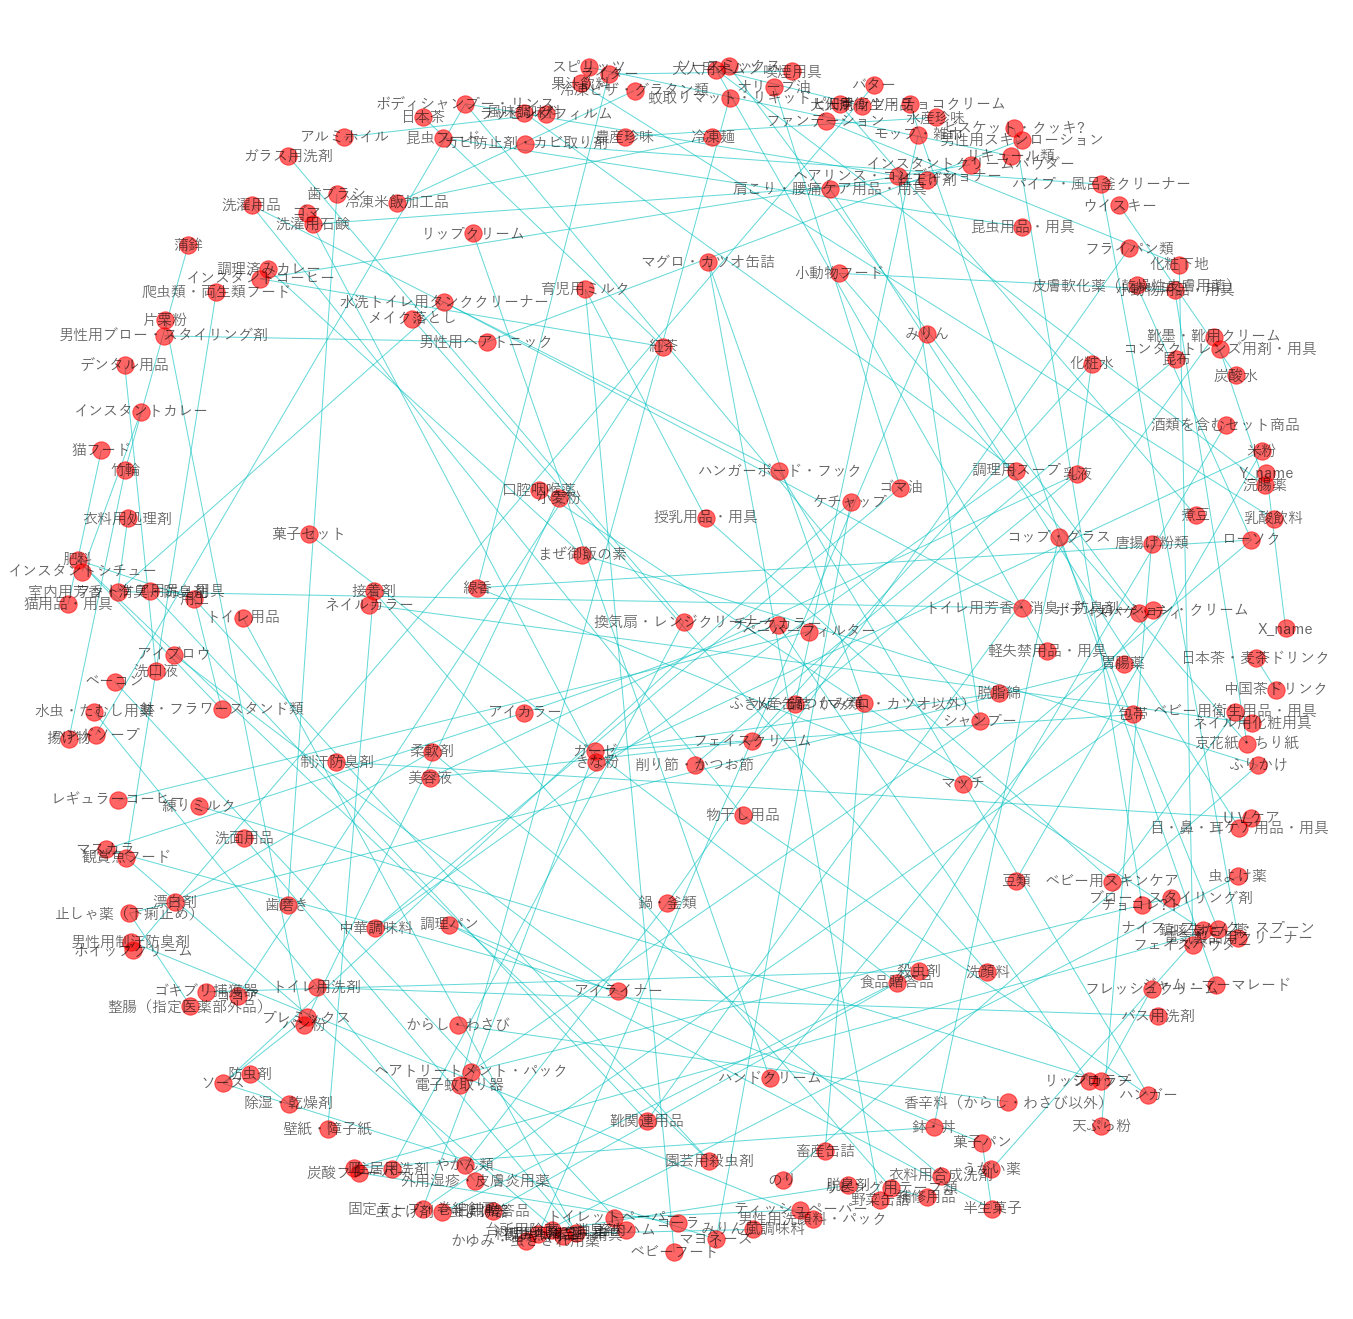

In [9]:
# networkxで可視化 (テキスト本文には掲載していないがGephiを利用せずにNetworkxで描画する方法を記載している)
import networkx as nx
import matplotlib.pyplot as plt
import pathlib

# 指標のランク3位以内の関係を選択
m_rules = Rules[(Rules['rankX-Y_jc'] <= 3) & (Rules['rankY-X_jc'] <= 3)
                & (Rules['rankX-Y_lift'] <= 3) & (Rules['rankY-X_lift'] <= 3)]

# edgeファイル作成
edge_data = m_rules.iloc[:, [1, 3]]
edge_data.to_csv('out/edge_data.csv', index=False)

# 環境に併せてフォントを選択
# Mac: YuGothic, Windows: MS Gothic Linux or Google Colab: IPAexGothic
font = 'YuGothic'
# font='IPAexGothic'
# font='MS Gothic


def graphDraw(file):

    # 拡張子を除くファイル名取得
    fname = (pathlib.Path(file)).stem
    # グラフの作成
    G = nx.Graph()

    # ファイルの読み込み
    G = nx.read_edgelist(file, delimiter=',', nodetype=str)
    print(nx.number_of_nodes(G))  # ノード数をカウントして出力
    print(nx.number_of_edges(G))  # エッジ数をカウントして出力

    # グラフ描画のレイアウトを決定。バネモデルでk=はノードの距離を決めるパラメーター
    pos = nx.spring_layout(G, k=0.8, seed=4)

    plt.figure(figsize=(24, 24))  # 図のサイズを決定 (単位はインチ)
    plt.axis('off')  # 軸は描画しない
    # ノードは赤色 (r)で透過率 (alpha=)60%、エッジはシアン (c)、文字サイズ 15インチ,フォントYuGothic(Mac),MS Gothic(Win),IPAexGothic(linux or Google Colab)
    nx.draw_networkx(G, pos, node_color='r', alpha=0.6,
                     edge_color='c', font_size=15, font_family=font)
    plt.savefig('out/%s.png' % (fname))


graphDraw('out/edge_data.csv')